In [10]:
# Cell 11: Setup for comprehensive plotting

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

print("✅ Plotly imported for interactive visualizations")

✅ Plotly imported for interactive visualizations


In [16]:
# Cell 1: Setup
"""
MODEL EXPERIMENTS NOTEBOOK
==========================
This is a rough notebook for trying different approaches.
Clean, final code will go in src/ files.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
    precision_score,
    recall_score,
    f1_score,
)

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import warnings

warnings.filterwarnings("ignore")

print("✅ Imports complete - Ready to experiment!")

✅ Imports complete - Ready to experiment!


In [2]:
# Cell 2: Load preprocessed data
df = pd.read_csv("../data/creditcard.csv")

X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[["Amount", "Time"]] = scaler.fit_transform(X_train[["Amount", "Time"]])
X_test_scaled[["Amount", "Time"]] = scaler.transform(X_test[["Amount", "Time"]])

print(f"✅ Data loaded: {X_train.shape[0]} training samples")

✅ Data loaded: 227845 training samples


In [3]:
# Cell 3: Experiment 1 - Baseline Logistic Regression

print("=" * 60)
print("EXPERIMENT 1: Baseline Logistic Regression")
print("=" * 60)

# Train
lr_model = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

# PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_lr)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.4f}")

EXPERIMENT 1: Baseline Logistic Regression

Confusion Matrix:
[[55478  1386]
 [    8    90]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962


ROC-AUC: 0.9721
PR-AUC: 0.7639


In [4]:
# Cell 4: Experiment 2 - XGBoost without SMOTE

print("=" * 60)
print("EXPERIMENT 2: XGBoost (No SMOTE)")
print("=" * 60)

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb_model_1 = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
)

xgb_model_1.fit(X_train_scaled, y_train)

y_pred_xgb1 = xgb_model_1.predict(X_test_scaled)
y_pred_proba_xgb1 = xgb_model_1.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb1))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb1))

print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb1):.4f}")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_xgb1)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.4f}")

EXPERIMENT 2: XGBoost (No SMOTE)

Confusion Matrix:
[[56839    25]
 [   15    83]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.85      0.81        98

    accuracy                           1.00     56962
   macro avg       0.88      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC: 0.9763
PR-AUC: 0.8676


In [5]:
# Cell 5: Experiment 3 - XGBoost WITH SMOTE

print("=" * 60)
print("EXPERIMENT 3: XGBoost + SMOTE")
print("=" * 60)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training: {len(y_train)} samples")
print(f"After SMOTE: {len(y_train_balanced)} samples")
print(f"Fraud ratio: {y_train_balanced.mean():.2%}")

# Train
xgb_model_2 = XGBClassifier(
    max_depth=6, learning_rate=0.1, n_estimators=100, random_state=42
)

xgb_model_2.fit(X_train_balanced, y_train_balanced)

# Predict
y_pred_xgb2 = xgb_model_2.predict(X_test_scaled)
y_pred_proba_xgb2 = xgb_model_2.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb2))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb2))

print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb2):.4f}")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_xgb2)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.4f}")

EXPERIMENT 3: XGBoost + SMOTE
Original training: 227845 samples
After SMOTE: 454902 samples
Fraud ratio: 50.00%

Confusion Matrix:
[[56717   147]
 [   13    85]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.37      0.87      0.52        98

    accuracy                           1.00     56962
   macro avg       0.68      0.93      0.76     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC: 0.9746
PR-AUC: 0.8413


In [6]:
# Cell 6: Compare All Models

print("=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)

models = {
    "Logistic Regression": (y_pred_lr, y_pred_proba_lr),
    "XGBoost (No SMOTE)": (y_pred_xgb1, y_pred_proba_xgb1),
    "XGBoost + SMOTE": (y_pred_xgb2, y_pred_proba_xgb2),
}

results = []
for name, (pred, proba) in models.items():
    roc_auc = roc_auc_score(y_test, proba)
    precision, recall, _ = precision_recall_curve(y_test, proba)
    pr_auc = auc(recall, precision)

    # Get recall and precision for fraud class
    report = classification_report(y_test, pred, output_dict=True)
    fraud_recall = report["1"]["recall"]
    fraud_precision = report["1"]["precision"]
    fraud_f1 = report["1"]["f1-score"]

    results.append(
        {
            "Model": name,
            "ROC-AUC": roc_auc,
            "PR-AUC": pr_auc,
            "Recall (Fraud)": fraud_recall,
            "Precision (Fraud)": fraud_precision,
            "F1-Score": fraud_f1,
        }
    )

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

MODEL COMPARISON SUMMARY
              Model  ROC-AUC   PR-AUC  Recall (Fraud)  Precision (Fraud)  F1-Score
Logistic Regression 0.972089 0.763921        0.918367           0.060976  0.114358
 XGBoost (No SMOTE) 0.976306 0.867643        0.846939           0.768519  0.805825
    XGBoost + SMOTE 0.974632 0.841350        0.867347           0.366379  0.515152


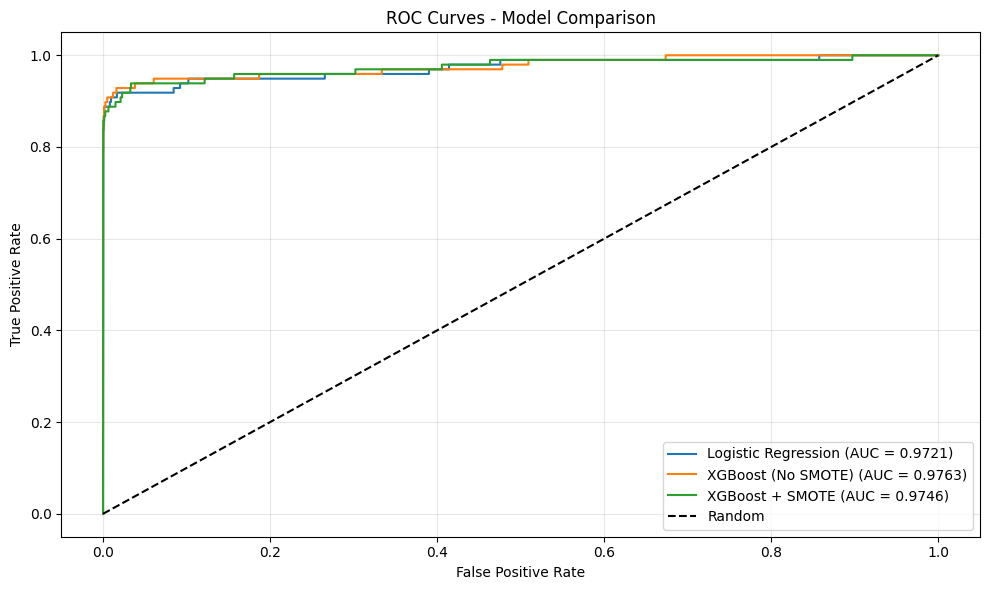

In [7]:
# Cell 7: Visualize ROC Curves

plt.figure(figsize=(10, 6))

for name, (_, proba) in models.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Model Comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

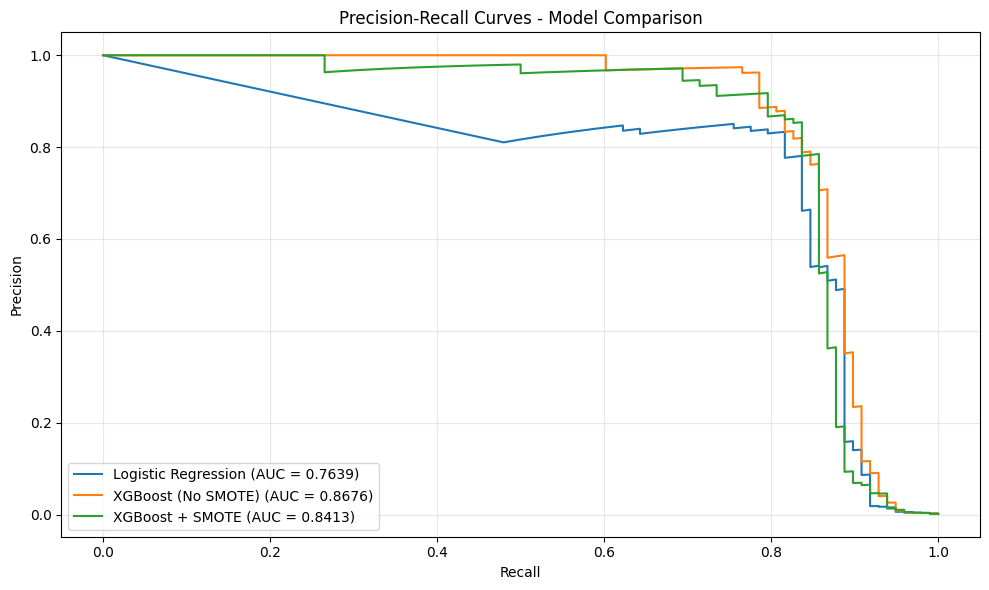

In [8]:
# Cell 8: Visualize Precision-Recall Curves

plt.figure(figsize=(10, 6))

for name, (_, proba) in models.items():
    precision, recall, _ = precision_recall_curve(y_test, proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AUC = {pr_auc:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves - Model Comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

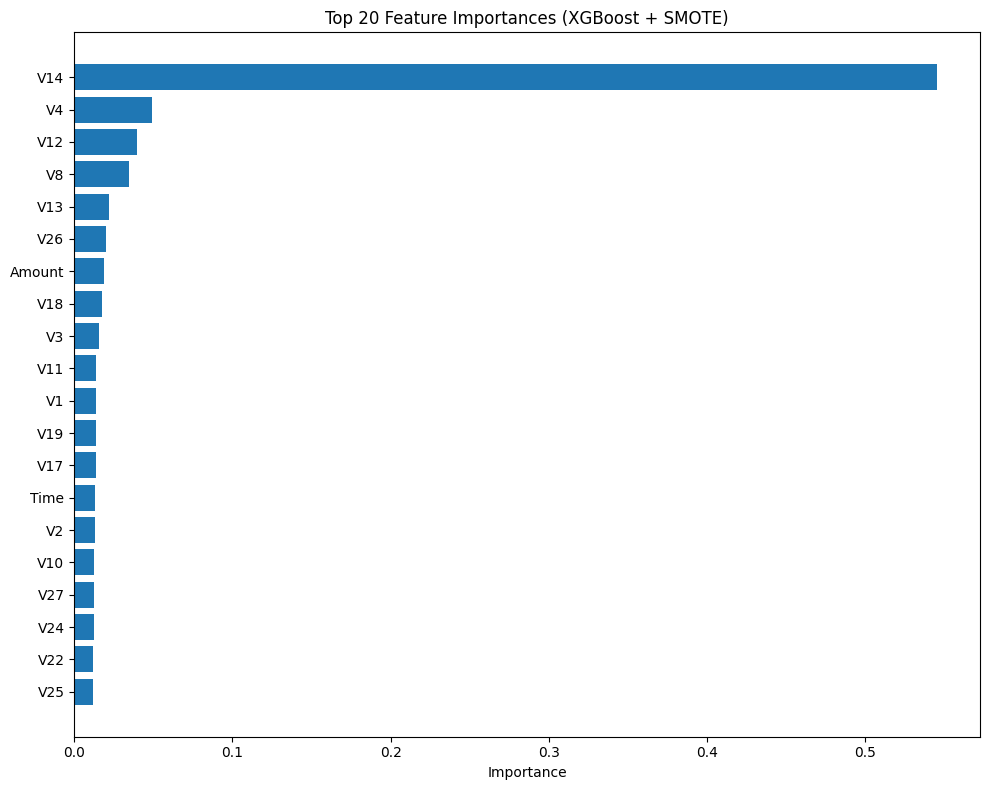


Top 10 Most Important Features:
   feature  importance
14     V14    0.545164
4       V4    0.049234
12     V12    0.039529
8       V8    0.034691
13     V13    0.022062
26     V26    0.019952
29  Amount    0.019134
18     V18    0.017555
3       V3    0.015859
11     V11    0.014070


In [9]:
# Cell 9: Feature Importance (Best Model)

# Using XGBoost + SMOTE model
feature_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": xgb_model_2.feature_importances_}
).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 8))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20["importance"])
plt.yticks(range(len(top_20)), top_20["feature"])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances (XGBoost + SMOTE)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

In [11]:
# Cell 12: Model Performance Metrics Comparison

fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=(
        "ROC-AUC Score",
        "PR-AUC Score",
        "Recall (Fraud Detection)",
        "Precision (Fraud)",
    ),
    specs=[[{"type": "bar"}, {"type": "bar"}], [{"type": "bar"}, {"type": "bar"}]],
)

model_names = results_df["Model"].tolist()
colors = ["#3498db", "#e74c3c", "#2ecc71"]

# ROC-AUC
fig.add_trace(
    go.Bar(
        x=model_names,
        y=results_df["ROC-AUC"],
        marker_color=colors,
        name="ROC-AUC",
        text=results_df["ROC-AUC"].round(4),
        textposition="outside",
    ),
    row=1,
    col=1,
)

# PR-AUC
fig.add_trace(
    go.Bar(
        x=model_names,
        y=results_df["PR-AUC"],
        marker_color=colors,
        name="PR-AUC",
        text=results_df["PR-AUC"].round(4),
        textposition="outside",
    ),
    row=1,
    col=2,
)

# Recall
fig.add_trace(
    go.Bar(
        x=model_names,
        y=results_df["Recall (Fraud)"],
        marker_color=colors,
        name="Recall",
        text=results_df["Recall (Fraud)"].round(4),
        textposition="outside",
    ),
    row=2,
    col=1,
)

# Precision
fig.add_trace(
    go.Bar(
        x=model_names,
        y=results_df["Precision (Fraud)"],
        marker_color=colors,
        name="Precision",
        text=results_df["Precision (Fraud)"].round(4),
        textposition="outside",
    ),
    row=2,
    col=2,
)

fig.update_layout(
    title_text="Model Performance Comparison",
    showlegend=False,
    height=700,
    font=dict(size=11),
)

fig.update_yaxes(range=[0, 1.1])
fig.show()

In [12]:
# Cell 13: Confusion Matrices for All Models

fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=("Logistic Regression", "XGBoost (No SMOTE)", "XGBoost + SMOTE"),
    specs=[[{"type": "heatmap"}, {"type": "heatmap"}, {"type": "heatmap"}]],
)

cms = [
    confusion_matrix(y_test, y_pred_lr),
    confusion_matrix(y_test, y_pred_xgb1),
    confusion_matrix(y_test, y_pred_xgb2),
]

for i, cm in enumerate(cms, 1):
    fig.add_trace(
        go.Heatmap(
            z=cm,
            x=["Predicted Legit", "Predicted Fraud"],
            y=["Actual Legit", "Actual Fraud"],
            colorscale="Blues",
            text=cm,
            texttemplate="%{text}",
            textfont={"size": 14},
            showscale=True if i == 3 else False,
        ),
        row=1,
        col=i,
    )

fig.update_layout(
    title_text="Confusion Matrices Comparison", height=400, font=dict(size=10)
)

fig.show()

# Print detailed confusion matrix analysis
print("\n" + "=" * 80)
print("CONFUSION MATRIX ANALYSIS")
print("=" * 80)

for name, (pred, _) in models.items():
    cm = confusion_matrix(y_test, pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"\n{name}:")
    print(f"  True Negatives (Legit correctly identified):  {tn:,}")
    print(f"  False Positives (Legit flagged as fraud):     {fp:,}")
    print(f"  False Negatives (Fraud missed):               {fn:,}")
    print(f"  True Positives (Fraud caught):                {tp:,}")
    print(f"  → Fraud Detection Rate: {tp}/{tp+fn} = {tp/(tp+fn)*100:.2f}%")
    print(f"  → False Alarm Rate: {fp}/{tn+fp} = {fp/(tn+fp)*100:.2f}%")


CONFUSION MATRIX ANALYSIS

Logistic Regression:
  True Negatives (Legit correctly identified):  55,478
  False Positives (Legit flagged as fraud):     1,386
  False Negatives (Fraud missed):               8
  True Positives (Fraud caught):                90
  → Fraud Detection Rate: 90/98 = 91.84%
  → False Alarm Rate: 1386/56864 = 2.44%

XGBoost (No SMOTE):
  True Negatives (Legit correctly identified):  56,839
  False Positives (Legit flagged as fraud):     25
  False Negatives (Fraud missed):               15
  True Positives (Fraud caught):                83
  → Fraud Detection Rate: 83/98 = 84.69%
  → False Alarm Rate: 25/56864 = 0.04%

XGBoost + SMOTE:
  True Negatives (Legit correctly identified):  56,717
  False Positives (Legit flagged as fraud):     147
  False Negatives (Fraud missed):               13
  True Positives (Fraud caught):                85
  → Fraud Detection Rate: 85/98 = 86.73%
  → False Alarm Rate: 147/56864 = 0.26%


In [13]:
# Cell 17: Radar Chart for Model Comparison

categories = ["ROC-AUC", "PR-AUC", "Recall", "Precision", "F1-Score"]

fig = go.Figure()

for idx, row in results_df.iterrows():
    fig.add_trace(
        go.Scatterpolar(
            r=[
                row["ROC-AUC"],
                row["PR-AUC"],
                row["Recall (Fraud)"],
                row["Precision (Fraud)"],
                row["F1-Score"],
            ],
            theta=categories,
            fill="toself",
            name=row["Model"],
        )
    )

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    showlegend=True,
    title="Model Performance Radar Chart",
    height=600,
    font=dict(size=12),
)

fig.show()

In [17]:
# Cell 18: Optimal Threshold Analysis for Best Model

# Using XGBoost + SMOTE (best model)
y_pred_proba = y_pred_proba_xgb2

# Calculate metrics at different thresholds
thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)

    if y_pred_thresh.sum() > 0:  # Avoid division by zero
        precision = precision_score(y_test, y_pred_thresh, zero_division=0)
        recall = recall_score(y_test, y_pred_thresh, zero_division=0)
        f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    else:
        precision = recall = f1 = 0

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Plot
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=thresholds,
        y=precisions,
        mode="lines",
        name="Precision",
        line=dict(color="blue", width=2),
    )
)
fig.add_trace(
    go.Scatter(
        x=thresholds,
        y=recalls,
        mode="lines",
        name="Recall",
        line=dict(color="red", width=2),
    )
)
fig.add_trace(
    go.Scatter(
        x=thresholds,
        y=f1_scores,
        mode="lines",
        name="F1-Score",
        line=dict(color="green", width=2),
    )
)

# Find optimal threshold (max F1)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

fig.add_vline(
    x=optimal_threshold,
    line_dash="dash",
    line_color="purple",
    annotation_text=f"Optimal={optimal_threshold:.3f}",
)

fig.update_layout(
    title="Threshold Analysis - XGBoost + SMOTE",
    xaxis_title="Classification Threshold",
    yaxis_title="Score",
    height=500,
    hovermode="x unified",
    font=dict(size=12),
)

fig.show()

print(f"\n{'='*80}")
print("OPTIMAL THRESHOLD ANALYSIS")
print(f"{'='*80}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Precision at optimal: {precisions[optimal_idx]:.4f}")
print(f"Recall at optimal: {recalls[optimal_idx]:.4f}")
print(f"F1-Score at optimal: {f1_scores[optimal_idx]:.4f}")


OPTIMAL THRESHOLD ANALYSIS
Optimal Threshold: 0.9798
Precision at optimal: 0.9167
Recall at optimal: 0.7857
F1-Score at optimal: 0.8462


In [ ]:
# Cell 19: Learning Curves for XGBoost + SMOTE

from sklearn.model_selection import learning_curve

print("Computing learning curves (this may take a few minutes)...")

train_sizes, train_scores, val_scores = learning_curve(
    XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=100, random_state=42),
    X_train_balanced,
    y_train_balanced,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

fig = go.Figure()

# Training score
fig.add_trace(
    go.Scatter(
        x=train_sizes,
        y=train_mean,
        mode="lines+markers",
        name="Training Score",
        line=dict(color="blue", width=2),
        marker=dict(size=8),
    )
)

fig.add_trace(
    go.Scatter(
        x=np.concatenate([train_sizes, train_sizes[::-1]]),
        y=np.concatenate([train_mean + train_std, (train_mean - train_std)[::-1]]),
        fill="toself",
        fillcolor="rgba(0,100,250,0.2)",
        line=dict(color="rgba(255,255,255,0)"),
        showlegend=False,
        name="Training ±1 std",
    )
)

# Validation score
fig.add_trace(
    go.Scatter(
        x=train_sizes,
        y=val_mean,
        mode="lines+markers",
        name="Validation Score",
        line=dict(color="red", width=2),
        marker=dict(size=8),
    )
)

fig.add_trace(
    go.Scatter(
        x=np.concatenate([train_sizes, train_sizes[::-1]]),
        y=np.concatenate([val_mean + val_std, (val_mean - val_std)[::-1]]),
        fill="toself",
        fillcolor="rgba(250,0,0,0.2)",
        line=dict(color="rgba(255,255,255,0)"),
        showlegend=False,
        name="Validation ±1 std",
    )
)

fig.update_layout(
    title="Learning Curves - XGBoost + SMOTE",
    xaxis_title="Training Set Size",
    yaxis_title="ROC-AUC Score",
    height=500,
    font=dict(size=12),
)

fig.show()

print("✅ Learning curves complete!")

In [19]:
# Cell 20: Styled Results Summary Table

print("\n" + "=" * 100)
print("FINAL MODEL COMPARISON SUMMARY")
print("=" * 100)

# Create styled dataframe
summary = results_df.copy()
summary["ROC-AUC"] = summary["ROC-AUC"].apply(lambda x: f"{x:.4f}")
summary["PR-AUC"] = summary["PR-AUC"].apply(lambda x: f"{x:.4f}")
summary["Recall (Fraud)"] = summary["Recall (Fraud)"].apply(lambda x: f"{x:.4f}")
summary["Precision (Fraud)"] = summary["Precision (Fraud)"].apply(lambda x: f"{x:.4f}")
summary["F1-Score"] = summary["F1-Score"].apply(lambda x: f"{x:.4f}")

print(summary.to_string(index=False))

# Highlight best model
print("\n" + "=" * 100)
best_model_idx = results_df["F1-Score"].idxmax()
best_model = results_df.loc[best_model_idx, "Model"]
print(f"🏆 BEST MODEL: {best_model}")
print(f"   - Highest F1-Score: {results_df.loc[best_model_idx, 'F1-Score']:.4f}")
print(f"   - ROC-AUC: {results_df.loc[best_model_idx, 'ROC-AUC']:.4f}")
print(
    f"   - Fraud Detection Rate (Recall): {results_df.loc[best_model_idx, 'Recall (Fraud)']*100:.2f}%"
)
print("=" * 100)

# Business Impact
print("\n" + "=" * 100)
print("BUSINESS IMPACT ANALYSIS")
print("=" * 100)

for idx, row in results_df.iterrows():
    model_name = row["Model"]
    recall = row["Recall (Fraud)"]
    precision = row["Precision (Fraud)"]

    total_fraud = y_test.sum()
    fraud_caught = int(recall * total_fraud)
    fraud_missed = total_fraud - fraud_caught

    legit_count = len(y_test) - total_fraud
    false_alarms = (
        int((1 - precision) * fraud_caught / precision) if precision > 0 else 0
    )

    print(f"\n{model_name}:")
    print(f"  Fraud Cases Detected: {fraud_caught}/{total_fraud} ({recall*100:.1f}%)")
    print(f"  Fraud Cases Missed: {fraud_missed} ({(1-recall)*100:.1f}%)")
    print(f"  False Alarms: {false_alarms} legitimate transactions flagged")
    print(f"  False Alarm Rate: {false_alarms/legit_count*100:.3f}%")


FINAL MODEL COMPARISON SUMMARY
              Model ROC-AUC PR-AUC Recall (Fraud) Precision (Fraud) F1-Score
Logistic Regression  0.9721 0.7639         0.9184            0.0610   0.1144
 XGBoost (No SMOTE)  0.9763 0.8676         0.8469            0.7685   0.8058
    XGBoost + SMOTE  0.9746 0.8413         0.8673            0.3664   0.5152

🏆 BEST MODEL: XGBoost (No SMOTE)
   - Highest F1-Score: 0.8058
   - ROC-AUC: 0.9763
   - Fraud Detection Rate (Recall): 84.69%

BUSINESS IMPACT ANALYSIS

Logistic Regression:
  Fraud Cases Detected: 90/98 (91.8%)
  Fraud Cases Missed: 8 (8.2%)
  False Alarms: 1385 legitimate transactions flagged
  False Alarm Rate: 2.436%

XGBoost (No SMOTE):
  Fraud Cases Detected: 83/98 (84.7%)
  Fraud Cases Missed: 15 (15.3%)
  False Alarms: 25 legitimate transactions flagged
  False Alarm Rate: 0.044%

XGBoost + SMOTE:
  Fraud Cases Detected: 85/98 (86.7%)
  Fraud Cases Missed: 13 (13.3%)
  False Alarms: 147 legitimate transactions flagged
  False Alarm Rate: 0.25

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("scaler", StandardScaler()), ("model", xgb_model_1)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [22]:
import joblib

joblib.dump(pipeline, "../models/creditfraud_pipeline.pkl")

['../models/creditfraud_pipeline.pkl']

In [ ]:
loaded_model = joblib.load("../models/creditfraud_pipeline.pkl")
loaded_model.predict(X_test[:5])

array([0, 0, 0, 0, 0])